In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Obtener los datos históricos de las acciones de Amazon
symbol = 'AMZN'
start_date = '2005-01-01'
end_date = '2023-07-01'
data = yf.download(symbol, start=start_date, end=end_date)



[*********************100%***********************]  1 of 1 completed


In [2]:

# Selecciona solo los precios de cierre ajustados
ts = data['Adj Close'].resample('D').interpolate()


In [3]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    print(f'ADF Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC') # dropna maneja los datos faltantes (NaN)
    
    labels = ['ADF Test Statistic', 'p-value', '# Lags Used', '# Observations']
    out = pd.Series(result[0:4], index=labels)

    for key,val in result[4].items():
        out[f'Critical Value ({key})'] = val
        
    print(out.to_string())          
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

# Luego puedes usar esta función en tus datos así:
adf_test(data['Adj Close'], 'Stock Price')


ADF Test: Stock Price
ADF Test Statistic        -0.293814
p-value                    0.926376
# Lags Used               31.000000
# Observations          4623.000000
Critical Value (1%)       -3.431765
Critical Value (5%)       -2.862165
Critical Value (10%)      -2.567103
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [4]:
# Diferenciación: Calcula la diferencia entre el valor actual y el valor anterior.
data['Adj Close diff'] = data['Adj Close'].diff()

# Eliminar la primera línea porque es NaN
data = data.dropna()

# Mostrar los primeros cinco registros
print(data.head())

# Realizar la prueba ADF de nuevo en los datos diferenciados
result = adfuller(data['Adj Close diff'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


              Open    High     Low   Close  Adj Close     Volume  \
Date                                                               
2005-01-04  2.1335  2.1630  2.0750  2.1070     2.1070  388370000   
2005-01-05  2.0785  2.1380  2.0780  2.0885     2.0885  167084000   
2005-01-06  2.0905  2.1125  2.0450  2.0525     2.0525  174018000   
2005-01-07  2.0690  2.1345  2.0580  2.1160     2.1160  196732000   
2005-01-10  2.0970  2.1480  2.0855  2.0920     2.0920  146958000   

            Adj Close diff  
Date                        
2005-01-04         -0.1190  
2005-01-05         -0.0185  
2005-01-06         -0.0360  
2005-01-07          0.0635  
2005-01-10         -0.0240  
ADF Statistic: -11.760721
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [9]:

# Divide los datos en un conjunto de entrenamiento y un conjunto de prueba
train_size = int(len(ts) * 0.8)
train, test = ts[0:train_size], ts[train_size:len(ts)]

In [10]:
from pmdarima.arima import auto_arima

# Define los rangos para p, d, q
p_range = range(0, 8)
d_range = range(0, 3)
q_range = range(0, 8)

# Llama a la función auto_arima
model = auto_arima(train, start_p=min(p_range), start_q=min(q_range), 
                   max_p=max(p_range), max_d=max(d_range), max_q=max(q_range), 
                   seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
model_fit = model.fit(train)


Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=11134.653, Time=0.32 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=9663.863, Time=0.27 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.57 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=11132.653, Time=0.13 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=9008.152, Time=0.47 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=8745.308, Time=0.62 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=8555.798, Time=0.77 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=8443.392, Time=0.96 sec
 ARIMA(6,2,0)(0,0,0)[0] intercept   : AIC=8269.097, Time=1.04 sec
 ARIMA(7,2,0)(0,0,0)[0] intercept   : AIC=8198.082, Time=2.04 sec


In [ ]:
# Hacer predicciones en el conjunto de prueba
predictions = model_fit.predict(n_periods=len(test))
# Calcula el error cuadrático medio en las predicciones
mse = mean_squared_error(test, predictions)
print('MSE: %.3f' % mse)

MSE: 2236.011


In [ ]:
predictions

2022-05-26    105.358573
2022-05-27    105.128020
2022-05-28    104.903031
2022-05-29    104.826581
2022-05-30    104.027115
                 ...    
2022-12-26     33.201747
2022-12-27     32.863687
2022-12-28     32.525627
2022-12-29     32.187568
2022-12-30     31.849508
Freq: D, Length: 219, dtype: float64

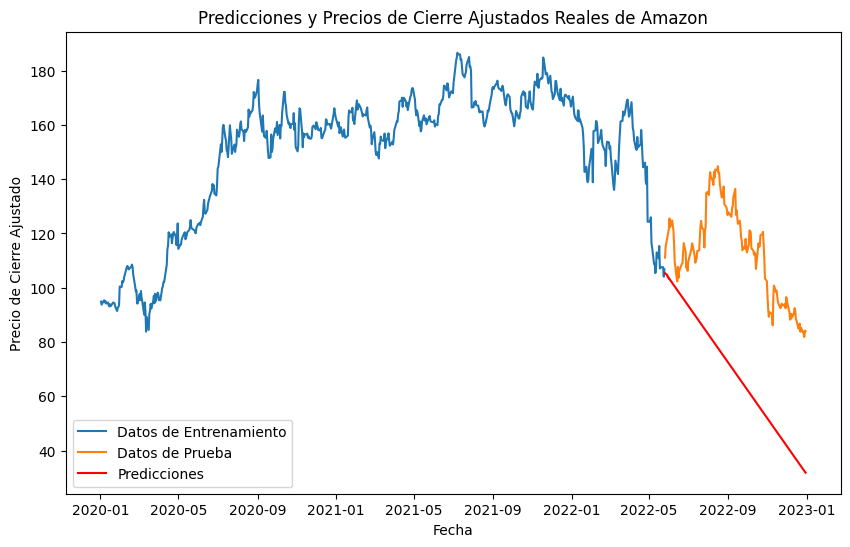

In [ ]:
# Visualiza las predicciones y los datos reales
plt.figure(figsize=(10,6))
plt.plot(train, label='Datos de Entrenamiento')
plt.plot(test.index, test.values, label='Datos de Prueba')
plt.plot(test.index, predictions, label='Predicciones', color='red')
plt.title('Predicciones y Precios de Cierre Ajustados Reales de Amazon')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre Ajustado')
plt.legend()
plt.show()

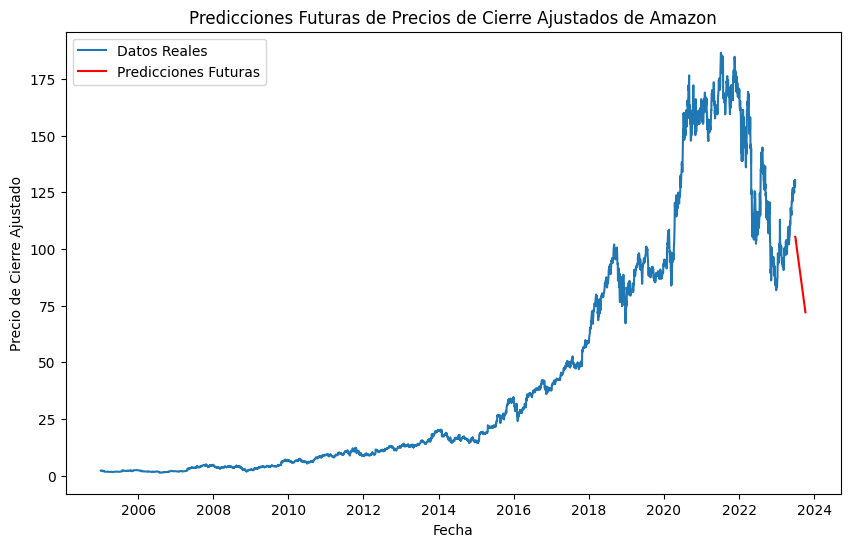

In [ ]:
# Realiza predicciones para el futuro
future_periods = 100
future_predictions = model_fit.predict(n_periods=future_periods)

# Crea un índice de fechas para las predicciones futuras
future_index = pd.date_range(start=ts.index[-1], periods=future_periods + 1, freq='D')[1:]

# Visualiza las predicciones para el futuro
plt.figure(figsize=(10,6))
plt.plot(ts, label='Datos Reales')
plt.plot(future_index, future_predictions, label='Predicciones Futuras', color='red')
plt.title('Predicciones Futuras de Precios de Cierre Ajustados de Amazon')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre Ajustado')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
mae = mean_absolute_error(test, predictions)
mape = np.mean(np.abs((test - predictions) / test)) * 100

print('MSE: %.3f' % mse)
print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % mae)
print('MAPE: %.3f' % mape)


MSE: 2236.011
RMSE: 47.286
MAE: 44.021
MAPE: 39.646
